# Assignment 2: Statistical inference
## [Scientific Computing with Python](https://scicompy.yoavram.com/)
## Yoav Ram

In [1]:
!~/anaconda3_501/bin/python -m pip install emcee

In [2]:
!~/anaconda3_501/bin/python -m pip install corner

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pandas as pd
import emcee
from corner import corner
import seaborn as sns
sns.set_context('notebook')
sns.set_palette('muted')

import zipfile
import urllib.request
import os

red, blue, green = sns.color_palette('Set1', 3)

# General instructions

1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that there are 2 exercises and the last cell in the notebook says **end of assignment**; if you are missing anything please download the origianl file from the course website.
1. This exercise doesn't put much emphasis on efficieny or runtime. *But*, your code should still run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, wherever possible to "lose your loops".
1. Questions regarding the exercises should be posted to the course forum at the designated group (i.e. "assignment2"). You can post questions anonymously. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the [course website](https://scicompy.yoavram.com/assignments).

# Exercise 1


In this analysis we will compare the body temperature of animals to check if indeed there is such a thing as [warm-blooded](http://en.wikipedia.org/wiki/Warm-blooded) and cold-blooded animals.

## Data loading and preprocessing

We start by loading the data.

In [4]:
###
url = 'http://genomics.senescence.info/species/dataset.zip'
fname = '../data/anage_dataset.zip'
if not os.path.exists(fname):
    urllib.request.urlretrieve(url, fname)
print("Data file exists:", os.path.exists(fname))

Data file exists: True


In [5]:
###
with zipfile.ZipFile(fname) as z:
    f = z.open('anage_data.txt')
    data = pd.read_table(f)

The temperatures are in Kelvin degrees in the `Temperature (K)` column, and we like Celsius degrees.
So we transform the temperature to Celsius and save the result in a new column.

Note: SciPy has a special function for Kelvin to Celsius conversion.

In [6]:
###
from scipy.constants import convert_temperature
data['Temperature (C)'] = convert_temperature(data['Temperature (K)'], 'K', 'C')

Next, we clean the data frame from rows with missing values in the temperature column.
We remove from the data classes with fewer than 10 species -- these are the birds.

In [7]:
###
data = data[np.isfinite(data['Temperature (C)'])]
data['Class'].value_counts()

Mammalia    457
Amphibia     18
Reptilia     16
Aves          3
Name: Class, dtype: int64

In [8]:
data = data[data["Class"] != 'Aves'] ###

We are left with mammals, reptiles, and amphibians.

We collate together the non-mammals (reptiles and amphibians).

In [9]:
mammals = data['Class'] == 'Mammalia' ###

**Plot a histogram of the temperature**: one histogram for mammals, and one histogram for amphibians and reptiles.

Plot the histograms on the same figure. Use `density=True` so that the histograms will be normalized, since there are many more mammals.

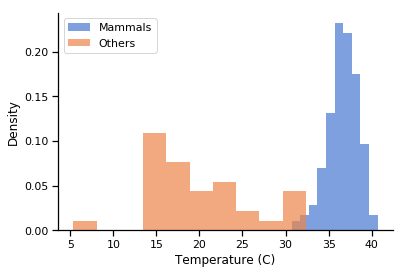

In [10]:
fig, axs = plt.subplots()
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

not_mammals = data['Class'] != 'Mammalia'
data_mammals = data[mammals]
data_not_mammals = data[not_mammals]
axs.hist(data_mammals['Temperature (C)'], density=True, alpha=0.7, label="Mammals")
axs.hist(data_not_mammals['Temperature (C)'], density=True,alpha=0.7,label="Others")
plt.xlabel('Temperature (C)')
plt.ylabel('Density')
plt.legend()
plt.show()

## Frequentist approach: t-test

OK. Now we want to compare these two empirical distribution: do they come from the same distribution? What is the probability that there is no difference between mammals and amphibians/reptiles, and that the difference we see in the dataset is a fluke?

The standard frequntist approach for this is [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test), which is used _"to determine if the means of two sets of data are significantly different from each other."_

This test assumes that the data are normally distributed around the mean (the histogram looks OK, I guess), but it also assumes that the variance is equal in the two distibutions, which doesn't seem to be the case.

A more robust test is [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test). 
The test statistic is defined as:
$$
t=\frac{\bar{X}_{1}-\bar{X}_{2}}{\sqrt{\frac{s_{1}^{2}}{N_{1}}+\frac{s_{2}^{2}}{N_{2}}}},
$$
where $X_i$ is dataset $i$, $\bar{X}_i$ is it's mean, $s_i$ it's standard deviation, and $N_i$ it's size.

The numerator is just the difference in means - we want to test if this is dignificantly different than zero.
The denominator scales the mean difference using an estimate of the standard errors of the means.

Welch's test assumes normality, but not equal variance.

**Compute $t$ and print it.**

In [11]:
X1 = data.loc[mammals, 'Temperature (C)'].values ###
X2 = data.loc[~mammals, 'Temperature (C)'].values ###

s1 = np.std(X1, dtype=np.float64)
s2 = np.std(X2, dtype=np.float64)

N1 = X1.size
N2 = X2.size

t = (X1.mean()-X2.mean())/(np.sqrt((np.square(s1)/(N1-1))+(np.square(s2)/(N2-1))))

print('t = {:.3f}'.format(t))

t = 16.454


Welch showed that that $t$ is approximately t-distributed:

$$
t \sim \mathbb{t}(\nu)
$$

where the parameter $\nu$ for the distribution of $t$ is
$$
\nu \approx \frac{\left(\frac{s_{1}^{2}}{N_{1}}+\frac{s_{2}^{2}}{N_{2}}\right)^{2}}{\frac{s_{1}^{4}}{N_{1}^{2} \nu_{1}}+\frac{s_{2}^{4}}{N_{2}^{2} \nu_{2}}}
$$
where $\nu_i = N_i-1$. We won't get into how this is all constructed -- this requires some mathematical abckground.

However, we will compute the probability to draw from $\mathbb{t}(\nu)$ a value as extreme as $t$.
We will print this probability, which is commonly called the _p-value_ of the test.

This p-value tells gives us what we were looking for: the probability that the two distributions actually have the same mean, despite the disparity we see.
As you will see, the p-value is extremely low, and therefore we can reject the hypothesis (which is usually called the null hypothesis) that there is no difference between the temperature of mammals and amphibians/reptiles.

_Note:_ we use `scipy.stats.t.sf(x) * 2` (`sf(x) = 1 - cdf(x)`), which returns the probability to get a value as extreme (very large or very small) as `x`. This "very small or very large" is considered a two-sided test: we want to if either mean is much greater than the other one.

In [12]:
###
ν = (s1 * s1 / N1 + s2 * s2 / N2)**2 / (s1**4 / (N1*N1*(N1-1)) + s2**4 / (N2 * N2 * (N2-1)))

pvalue = scipy.stats.t.sf(t, ν) * 2
print('p-value: {:.2g}'.format(pvalue)) 

p-value: 1.3e-17


By the way, we could have just used `scipy.stats.ttest`. Here's how to do that:

In [13]:
t, pvalue = scipy.stats.ttest_ind(X1, X2, equal_var=False)
print("P-value: {:.2g} (t={:.3f})".format(pvalue, t))

P-value: 1.4e-17 (t=16.454)


In [14]:
###
t, pvalue = scipy.stats.ttest_ind(X1, X2, equal_var=False)
print("P-value: {:.2g} (t={:.3f})".format(pvalue, t))

P-value: 1.4e-17 (t=16.454)


## Bayesian approach: BEST

Now let's do this using Bayesian statistics, with an approach called BEST ([Bayesian Estimation Supersedes the T-test](https://psycnet.apa.org/fulltext/2012-18082-001.pdf)).

The nice thing is that once we understand Bayesian inference, we can easily understand BEST; whereas with the t-test, we need to specifically understand t-distributions, which looks very complicated.

How are we modelling the data?
Similarly to the t-test, we assume normality:

$$
X_1 \sim N(\mu_1, \sigma_1^2) \\
X_2 \sim N(\mu_2, \sigma_2^2)
$$

So the model parameters are $\theta=(\mu_1, \mu_2, \sigma_1, \sigma_2)$.

**Start by infering $\theta$** using _emcee_ (or your own MCMC code if you prefer).

To have a full description of our model we need to specify the prior for $\theta$.
We provide wide priors for $\mu_i$ around the sample mean, and some exponential prior for the standard deviation terms: 

$$
\mu_i \sim N(\bar{X}, 1000), \\
\sigma_i \sim Exp(10)
$$

here $\bar{X}$ is the mean of all the samples (including all of $X_1$ and $X_2$), and $Exp(10)$ is an exponential distribution with mean 10 (implemented with `scipy.stats.expon(scale=10)`).

In [15]:
X = np.concatenate((X1, X2)) ###
Xbar = X.mean() ###

def log_prior(θ): ###
    μ1, μ2, σ1, σ2 = θ

    μ1_p = scipy.stats.norm.logpdf(μ1, loc=Xbar, scale=np.sqrt(1000))
    μ2_p = scipy.stats.norm.logpdf(μ2, loc=Xbar, scale=np.sqrt(1000))
    σ1_p = scipy.stats.expon.logpdf(σ1, scale=10)
    σ2_p = scipy.stats.expon.logpdf(σ2, scale=10)
    μ_p = μ1_p + μ2_p
    σ_p = σ1_p + σ2_p
    return μ_p + σ_p
    
def log_likelihood(θ, X1, X2): ###
    μ1, μ2, σ1, σ2 = θ
    log_likelihood1 = (-0.5) * (np.log(2*np.pi*(σ1*σ1))+(X1-μ1)**2 / (σ1*σ1)).sum()
    log_likelihood2 = (-0.5) * (np.log(2*np.pi*(σ2*σ2))+(X2-μ2)**2 / (σ2*σ2)).sum()
    log_likelihood = log_likelihood1+log_likelihood2
    return log_likelihood

def log_posterior(θ, X1, X2): ###
    log_pr = log_prior(θ)
    if not np.isinf(log_pr):
        return log_pr + log_likelihood(θ, X1, X2)
    else:
        return log_pr  
    

In [16]:
ndim = 4  # number of parameters in the model
nwalkers = 20 # number of MCMC walkers
nsteps = 10000 // nwalkers  # number of MCMC steps to take
nburn = nsteps // 2  # "burn-in" period to let chains stabilize

guesses = np.empty((nwalkers, ndim)) ###

guesses = 2000 * np.random.rand(nwalkers, ndim)

In [17]:
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, 
    ndim=ndim,
    log_prob_fn=log_posterior,
    args=[X1,X2]
)
sampler.run_mcmc(
    initial_state=guesses,
    nsteps=nsteps
);

After inferring the parameters, we plot a trace plot to make sure the Markov chain has converged.

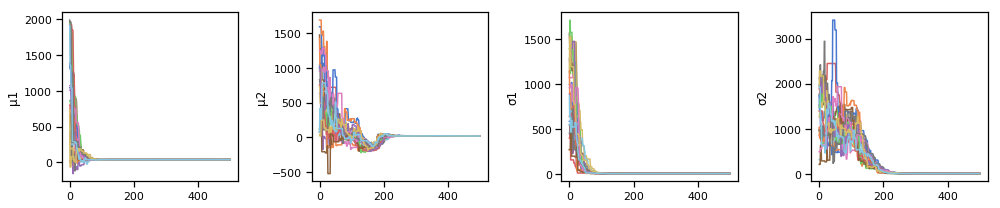

In [18]:
###
fig, axes = plt.subplots(1, 4, figsize=(14, 3), sharex=True)

for i, label in enumerate(['μ1', 'μ2', 'σ1', 'σ2']):
    for j in range(nwalkers):
        axes[i].plot(sampler.chain[j, :, i])
        axes[i].set_ylabel(label)
fig.tight_layout()

**Take the samples after the burnin period** and reshape if required (for example if you used more then one chain/walker).

In [19]:
samples = sampler.chain[:,nburn:,:].reshape(-1,4)

**Plot a corner plot** to examine the posterior. It should show nice gaussians, both on and off the diagonal.

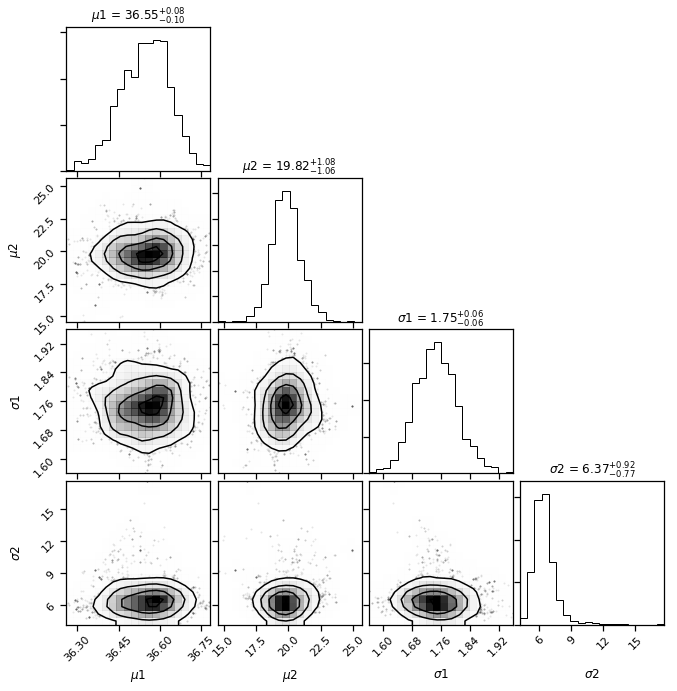

In [20]:
cor =corner(samples, 
       smooth=True, 
       show_titles=True,
       labels=['$\mu1$', '$\mu2$', '$\sigma1$', '$\sigma2$'],
);

Finally, we can do the Bayesian estimation for the difference between the means $\mu_1$ and $\mu_2$ by computing the posterior of the difference $\Delta\mu = \mu_1 - \mu_2$:
- **compute the difference** between the posterior samples of $\mu_1$ and $\mu_2$ to get posterior samples of $\Delta\mu$,
- **plot the histogram of the posterior** of $\Delta\mu$ (note how far the distribution is from zero!),
- **print the probability that $\mu_1>\mu_2$** according to the posterior of $\Delta\mu$.

P(μ1 > μ2) = 1.0


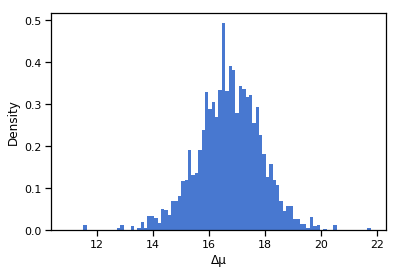

In [21]:
Δμ  = (samples[:,0] - samples[:,1])

sns.distplot(Δμ,norm_hist=True , bins = 90 , kde=False , hist_kws={'alpha':1})
plt.ylabel('Density')
plt.xlabel('Δμ')
Δμ_prob = (samples[:,0] > samples[:,1]).sum() / samples[:,1].size
print(f'P(μ1 > μ2) = {Δμ_prob}')

We therefore infer that $P(\mu_1 > \mu_2) \approx 1$, that is, that the _mean temperature of mammals is larger than that of amphibians/reptiles with very high confidence_.

# Exercise 2

In this exercise we will attempt to model the number of days between COVID-19-related hospitalization and death, and infer the model parameters from data.

The data was recorded in Hubei province of China, and retrieved from [Xu & Kraemer, Lancet 2020](https://doi.org/10.1016/S1473-3099(20)30119-5).

The data was filtered to include data for patients that were admitted to hospitals in Hubei (mostly Wuhan) during Jan 2020 and that died in the hospital.

In [22]:
###
df = pd.read_csv('../data/covid-19_line_list_Hubei_9Feb.csv', index_col=0)
df

,date_admission_hospital,outcome,date_death_or_discharge
60,16.01.2020,died,20.01.2020
62,18.01.2020,died,19.01.2020
64,03.01.2020,died,15.01.2020
65,05.01.2020,died,18.01.2020
66,11.01.2020,died,20.01.2020
67,14.01.2020,died,21.01.2020
69,18.01.2020,died,22.01.2020
70,06.01.2020,died,22.01.2020
71,11.01.2020,died,21.01.2020
72,18.01.2020,died,22.01.2020


- **Convert the date columns to `datetime`**
- **Compute the array `X`** of the number of days in the hospital for each patient.
- **Plot a histogram of `X`**; make sure to add axes labels.

In [23]:
# Converting collumns to datetime objects
df['date_admission_hospital'] = pd.to_datetime(df['date_admission_hospital'], dayfirst=True)
df['date_death_or_discharge'] = pd.to_datetime(df['date_death_or_discharge'], dayfirst=True)

# Creating an array of days
days = []
for index, row in df.iterrows():
    num_of_days = row['date_death_or_discharge'] - row['date_admission_hospital']
    days.append(num_of_days.days)
X = np.array(days)

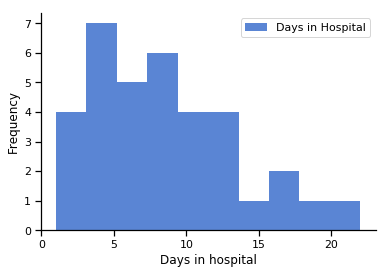

In [24]:
# Plotting the histogram
fig, axs = plt.subplots()
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.hist(X, label="Days in Hospital",alpha=0.9)
plt.xlabel('Days in hospital')
plt.ylabel('Frequency')
plt.legend()
plt.show()

A good model for the number of days before death is the [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution), which is commonly used to model time-to-failure. 
In Weibull, the failure rate, or the probability for failure per time unit, is proportional to a power of time. 

Weibull has two parameters:

- $\lambda$ is the basic failure rate
- $k$ is the power plus one; therefore, 
 - when $k<1$ the failure rate decreases with time; this occurs for example with infants (in general, not connected to COVID-19)
 - when $k=1$ the failure rate is constant in time; this corresponds to the exponential distribution and might occur if external factors unrelated to time are more important.
 - when $k>1$ the failure rate increases with time; this occurs for example if the available treatments are limited (as was the case in January), or if the hospital stay itself added risk.
 

The probability function of a Weibull distribution with parameters $\lambda$ and $k$ is

$$
P(x \mid \lambda, k) = \begin{cases}
\frac{k}{\lambda} \big(\frac{x}{\lambda}\Big)^{k-1} \exp\Big[{-\big(\frac{x}{\lambda}\big)^k}\Big], & x \ge 0, \\
0, & x < 0 
\end{cases}
$$

_Note 1_ that $k$ and $x$ look similar, so avoid making mistakes!

_Note 2_ This $P(x \mid \lambda, k)$ gives you the likelihood of $(\lambda, k)$ given $x$; this is not the log-likelihood! 

**Implement the log-likelihood function `log_likelihood(θ, X)`** for the Weibull distribution, $\logP(X \mid \lambda, k)$.

In [25]:
def log_likelihood(θ, X): ###
    𝜆, k = θ
    return (-(X/𝜆)**k+np.log(k/𝜆)+(k-1)*np.log(X/𝜆)).sum()

We now compute the log-likelihood for a range of $\lambda$ values and for the following $k$ values: $k=0.1$, $k=1$ (exponential distribution), $k=2$, and $k=4$.

We plot all the log-likelihoods we computed as a function of $\lambda$.

In [26]:
###
λ_range = np.linspace(X.min(), X.max()) 

# Exponential = Weibull k=1
ll_expon = [log_likelihood((λ_, 1), X) for λ_ in λ_range]

# Weibull
ll_weibull01 = [log_likelihood((λ_, 0.1), X) for λ_ in λ_range]
ll_weibull2 = [log_likelihood((λ_, 2), X) for λ_ in λ_range]
ll_weibull4 = [log_likelihood((λ_, 4), X) for λ_ in λ_range]

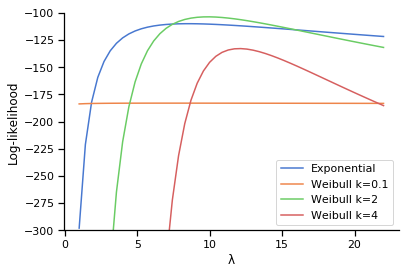

In [27]:
plt.plot(λ_range, ll_expon, label='Exponential')
plt.plot(λ_range, ll_weibull01, label='Weibull k=0.1')
plt.plot(λ_range, ll_weibull2, label='Weibull k=2')
plt.plot(λ_range, ll_weibull4, label='Weibull k=4')
plt.ylim(-300, -100)
plt.xlabel('λ')
plt.ylabel('Log-likelihood')
plt.legend()
sns.despine()

The above plot shows that the maximum likelihood estimate for $k$ is likely higher than 1 and lower than 4. 
Therefore, the exponential distribution ($k=1$) is likely inappropriate, and the **death rate likely increases every day in the hospital**.

Next, **compute the log-likelyhood for combinations of $\lambda$ and $k$ values**, and **find and print the MLE** (maximum likelihood estimate).

Then use the provided code to plot the log-likelihood plane and mark the MLE with green marker.

_Tip:_ when using `pcolormesh`, it is useful to manually set `vmin` and `vmax` to meaningful values; otherwise, extremely low log-likelihood will cause most of the plane to be of the same color. This is similar to manually setting `ylim` in the previous plot.

In [28]:
λ_range = np.linspace(X.min(), X.max(), 100) ###
k_range = np.linspace(1, 4, 51) ###

loglik = np.array([[log_likelihood((λ_, k_), X) for λ_ in λ_range] for k_ in k_range])
max_lik = np.max(loglik)
print('Max Likelihood estimate (MLE) = {:.2f}'.format(max_lik))

Max Likelihood estimate (MLE) = -103.14


In [29]:
k_hat,λ_hat = np.where(loglik == max_lik)
λ_hat = (λ_range[λ_hat]).item()
k_hat = (k_range[k_hat]).item()

print('λ_hat = {:.2f}, k_hat={:.2f}'.format(λ_hat, k_hat)) ###

λ_hat = 9.48, k_hat=1.72


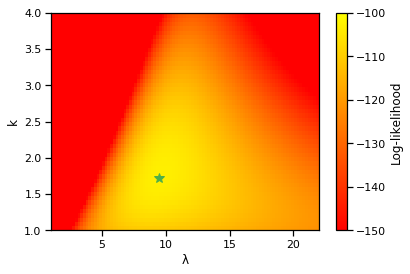

In [30]:
###
plt.pcolormesh(λ_range, k_range, loglik, cmap='autumn', vmin=-150, vmax=-100, rasterized=True)
plt.plot(λ_hat, k_hat, '*', markersize=10, color=green)
plt.xlabel('λ')
plt.ylabel('k')
plt.colorbar(label='Log-likelihood');

Now, we will estimate the joint posterior of $\lambda$ and $k$ using _emcee_.

- **Define `log_prior` and `log_posterior`**.
- **Make guesses of $\lambda$ and $k$ for each emcee walker** using the log-likelihood plots from above.
- **Run the emcee sampler to get samples from the posterior**.

Note: you can define the prior as a uniform in some range, consult with the log-likelihood plot above for an appropriate range.

In [31]:
def log_prior(θ): ###
    λ, k = θ
    if λ> 0 and k>0:
        return 0
    else:
        return -np.inf

def log_posterior(θ, X): ###
    log_pr = log_prior(θ)
    if np.isinf(log_pr): 
        return log_pr
    else: 
        return log_pr + log_likelihood(θ, X)

In [32]:
ndim = 2
nwalkers = 50
nsteps  = 10000 // nwalkers
nburn = nsteps // 2

guesses = np.random.rand(nwalkers, ndim)
guesses[:, 0] *= 20 
guesses[:, 1] *= 10

In [33]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[X])
sampler.run_mcmc(guesses, nsteps)

# sampler.chain.shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

**Get the $\lambda$ and $k$ samples** from the sampler in arrays called `λ_sample` and `k_sample`,

Then **Compute the MAP** (maximum a posterior estimate) of $\lambda$ and $k$ and set them to `λ_hat_mcmc` and `k_hat_mcmc`.
Then print them together with the MLE for comparison.



In [34]:
sample

array([[10.08833863,  1.44799395],
       [10.08833863,  1.44799395],
       [10.08833863,  1.44799395],
       ...,
       [ 9.21986179,  2.09641672],
       [10.41632742,  1.95656384],
       [10.41632742,  1.95656384]])

In [35]:
λ_sample = sample[:,0]
k_sample = sample[:,1]
λ_hat_mcmc = λ_sample.mean()
k_hat_mcmc = k_sample.mean()

print('MLE:  λ_hat = {:.2f}, k_hat={:.2f}'.format(λ_hat, k_hat)) ### 
print('MCMC: λ_hat = {:.2f}, k_hat={:.2f}'.format(λ_hat_mcmc, k_hat_mcmc)) ###

MLE:  λ_hat = 9.48, k_hat=1.72
MCMC: λ_hat = 9.90, k_hat=1.75


We plot a trace plot of both $\lambda$ and $k$.

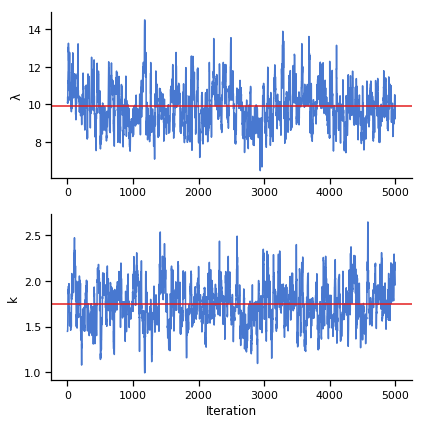

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
# Plot λ
axes[0].plot(λ_sample)
axes[0].axhline(λ_hat_mcmc, color=red)
# Plot the k samples
axes[1].plot(k_sample)
axes[1].axhline(k_hat_mcmc, color=red)
# Set the labels
axes[0].set(ylabel='λ')
axes[1].set(xlabel='Iteration', ylabel='k')
fig.tight_layout()
sns.despine()

**Plot the marginal and joint posterior distribution**.
Add lines and markers to show the MAP (red) and MLE (green).

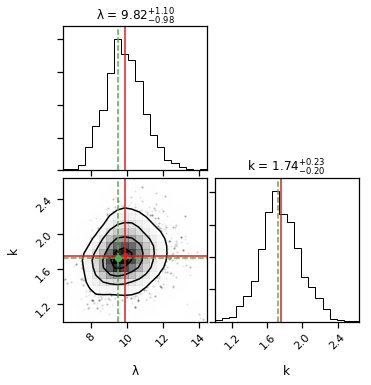

In [37]:
cor = corner(sample, 
    smooth=True,
    labels=['λ', 'k'],
    show_titles=True,
)
cor.axes[0].axvline(λ_hat_mcmc, color=red)
cor.axes[3].axvline(k_hat_mcmc, color=red)
cor.axes[2].axvline(λ_hat_mcmc, color=red)
cor.axes[2].axhline(k_hat_mcmc, color=red)
cor.axes[2].plot(λ_hat_mcmc, k_hat_mcmc, 'o', color=red);
cor.axes[0].axvline(λ_hat, color=green,ls='--')
cor.axes[3].axvline(k_hat, color=green,ls='--')
cor.axes[2].axvline(λ_hat, color=green,ls='--')
cor.axes[2].axhline(k_hat, color=green,ls='--')
cor.axes[2].plot(λ_hat, k_hat, 'o', color=green);

Now, we plot the survival function that gives the probability of survival after $x$ days (for a hospitalized patient that will eventually die in the hospital, so this is conditioned on death, like all our analysis).

The survival function is the complement of the cumulative distribution function. It can be written as:
$$
s(x) = \exp\Big[{-\big(\frac{x}{\lambda}\big)^k}\Big],
$$
where $x$ is the number of days since hospitalization and $s(x)$ is the probability to survive $x$ days.

In addition, we print the median number of days before death conditioned on eventual death.

Median survival days: 8.03


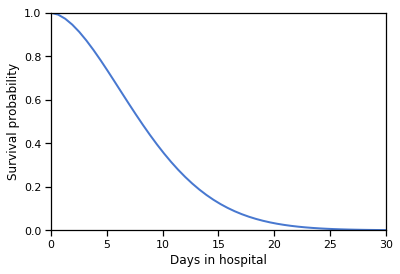

In [38]:
def survival_probability(θ, x):
    λ, k = θ
    return np.exp(-(x/λ)**k)

x_range = np.linspace(0, 31)
plt.plot(x_range, survival_probability((λ_hat_mcmc, k_hat_mcmc), x_range), lw=2)
plt.xlim(0, 30)
plt.ylim(0, 1)
plt.ylabel('Survival probability')
plt.xlabel('Days in hospital')

median = λ_hat_mcmc * np.log(2)**(1/k_hat_mcmc)
print("Median survival days: {:.2f}".format(median)) ###

**End of assignment**